In [1]:
import re
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain
from collections import Counter

from tqdm import tqdm
tqdm.pandas()

from sklearn.preprocessing import LabelEncoder

sys.path.append('../src')
from encode import *
from label_candidates_extract import LabelCandidatesExtracter

### Обучающая выборка

In [2]:
articles = pd.read_csv('../data/interim/articles_preproc.csv')

articles.title_preproc = articles.title_preproc.apply(conllu_encoder)
articles.text_preproc = articles.text_preproc.apply(conllu_encoder)

sentences = list(chain(*articles.title_preproc))+list(chain(*articles.text_preproc))

### Гистограмма количества слов в предложениях

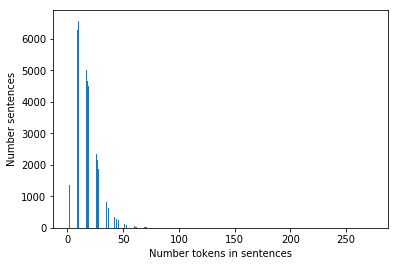

In [3]:
plt.figure()
plt.hist([len(sent.tokens) for sent in sentences], bins=1000)
plt.xlabel('Number tokens in sentences')
plt.ylabel('Number sentences')
plt.show()

Ограничем длину кандидата в заголовок 100 словами.

In [4]:
lce = LabelCandidatesExtracter(max_len=100).fit(sentences)

100%|██████████| 100/100 [03:24<00:00,  1.13it/s]


### Выделение кандидатов в заголовках и текстах статей

Сформируем таблицу candidates.csv кандидатов в заголовки:

* **article_id** - идентификатор новостной статьи
* **part** - часть статьи ('title', 'text')
* **sent_id** - идентификатор предложения
* **begin_index** - индекс, с которого начинается фраза в предложении 
* **end_index** - индекс, которым заканчивается фраза в предложении
* **form_id** - идентификатор кандидата (слова в изначальной грамматической форме)
* **lemma_id** - идентификатор кандидата (слова в нормальной грамматической форме)
* **sig** - sig из TopMine

Также будут таблицы candidate_forms.csv и candidate_lemmas.csv, в которых храняться соответсвующие фразы и их идентификаторы.

In [5]:
candidates = []

for _, article in tqdm(articles.iterrows()):
    
    for part in ['title', 'text']:
        for sentence in article[part+'_preproc']:
            for begin, end, sig in lce.transform(sentence):
            
                candidate = sentence.tokens[begin:end]
                
                #Не будем брать кандидаты начинающиеся или заканчивающиеся пунктуацией  
                if candidate[0].pos == 'PUNCT' or candidate[-1].pos == 'PUNCT':
                    continue
                    
                lemma = ''.join([token.lemma+' '*token.space for token in candidate]).strip()
                
                #Не будем брать кандидаты в которых нет букв
                if not re.match('[а-яёй]', lemma):
                    continue

                form = ''.join([token.token+' '*token.space for token in candidate]).strip()
    
                candidates.append((article.id, part, sentence.id, begin, end, form, lemma, sig))

columns = ['article_id', 'part', 'sent_id', 'begin_index', 'end_index', 'form_id', 'lemma_id', 'sig']
candidates = pd.DataFrame(candidates, columns=columns)

#оставляем только кандидатов, которые встречались более двух раз
candidate_lemma_counts = candidates.groupby('lemma_id').lemma_id.count()
candidate_lemma_counts = candidate_lemma_counts[candidate_lemma_counts.values > 2]

candidates = candidates[candidates.lemma_id.isin(candidate_lemma_counts.index)]
candidates.to_csv('../data/interim/candidates.csv', index=False)

#удаляем кандидаты, которые имеют не положительный sig
candidates = candidates[candidates.sig > 0]
candidates.to_csv('../data/interim/candidates.csv', index=False)

#формируем список кандидатов
label_encoder = LabelEncoder().fit(candidates.form_id)
candidates.form_id = label_encoder.transform(candidates.form_id)

candidate_forms = label_encoder.classes_
candidate_forms = pd.DataFrame({'id':range(len(candidate_forms)), 'candidate':candidate_forms})

candidate_forms.to_csv('../data/interim/candidate_forms.csv', index=False)

#формируем список лемм кандидатов
label_encoder = LabelEncoder().fit(candidates.lemma_id)
candidates.lemma_id = label_encoder.transform(candidates.lemma_id)

candidate_lemmas = label_encoder.classes_
candidate_lemmas = pd.DataFrame({'id':range(len(candidate_lemmas)), 'candidate':candidate_lemmas})

candidate_lemmas.to_csv('../data/interim/candidate_lemmas.csv', index=False)

11127it [01:20, 137.81it/s]


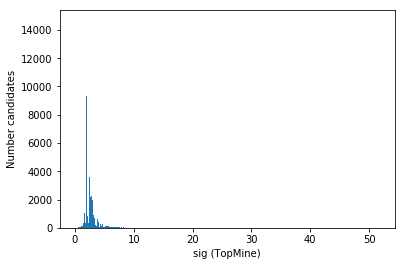

In [11]:
plt.figure()
plt.hist(candidates.groupby('lemma_id').sig.mean().values, bins=1000)
plt.ylabel('Number candidates')
plt.xlabel('sig (TopMine)')
plt.show()